In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
# GPU 사용 가능 여부 확인 -> GPU or CPU 선택

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


In [3]:
# 데이터 준비 1.
transform = transforms.Compose([transforms.ToTensor()])

In [4]:
# 데이터 준비 2.
train_dataset = datasets.CIFAR10(root="data_files",
                               train=True,
                               download=True,
                               # transform=transforms.ToTensor(),
                               transform=transform)

test_dataset = datasets.CIFAR10(root="data_files",
                              train=False,
                              download=True,
                              # transform=transforms.ToTensor(),
                              transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# 데이터 준비 3.

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=32,
                                          shuffle=False)

In [6]:
# 데이터 확인

for X, y in train_loader:
    print(X.shape, y.shape)
    break

torch.Size([32, 3, 32, 32]) torch.Size([32])


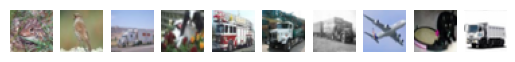

tensor([6, 2, 9, 5, 9, 9, 9, 0, 3, 9])

In [7]:
for idx in range(10):
    plt.subplot(1, 10, idx+1)
    plt.axis('off')
    plt.imshow(X[idx, :, :, :].permute(1, 2, 0))    # 컬러임
    # idx, 0차원, 1차원, 2차원, resahpe을 쓸 수도 있지만, 
    # permute는 tensor의 함수로, 디맨션의 위치를 바꿔줄 수 있다. 채널을 맨 뒤로 보냄
plt.show()
y[:10]

In [8]:
# 모델 구조 설계

class Cifar10Cnn(nn.Module):
    def __init__(self):
        super(Cifar10Cnn, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1) # 컬러라서 input channel 3임
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # 32 * 32 > 16 * 16 > 8 * 8
        self.fc1 = nn.Linear(8*8*16, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)        

        x = x.view(-1, 8*8*16)  # flatten, reshape 하는 것
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1) # log_softmax하면 음수로 나오고 softmax하면 양수로 나옴
        return x

In [9]:
# 학습 도구 구성
model = Cifar10Cnn().to(device)
# loss = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

print(model)

Cifar10Cnn(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [10]:
# 훈련 함수 정의 (학습 설계)
def train(model, train_loader, optimizer):
    model.train() # train mode로 설정
    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        if idx % 300 == 0:
            print(f"Batch : {idx}, Loss : {loss.item()}")

In [11]:
def evaluate(model, test_loader):
    loss_total = 0
    correct_total = 0
    model.eval() # evaluation mode로 설정 -> batch-normalization, drop-out 수행 중지
    with torch.no_grad(): # 가중치 업데이트 수행 중지
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels).item()
            loss_total += loss
            predicted_values = output.max(1, keepdim=True)[1]
            correct = predicted_values.eq(labels.view_as(predicted_values)).sum().item()
            correct_total += correct

    loss_total /= ( len(test_dataset) / 32 )
    accuracy = correct_total / len(test_dataset)

    return loss_total, accuracy



In [12]:
# 학습 실행

for epoch in range(10):    
    train(model, train_loader, optimizer)
    loss, accuracy = evaluate(model, test_loader)
    print(f"Epoch : {epoch + 1}, Loss: {loss}, Accuracy : {accuracy}")    

Batch : 0, Loss : 2.302161931991577
Batch : 300, Loss : 2.113511323928833
Batch : 600, Loss : 2.2752346992492676
Batch : 900, Loss : 2.185114860534668
Batch : 1200, Loss : 2.106966495513916
Batch : 1500, Loss : 2.0210399627685547
Epoch : 1, Loss: 2.0597490467071533, Accuracy : 0.4015
Batch : 0, Loss : 1.9163576364517212
Batch : 300, Loss : 2.066701889038086
Batch : 600, Loss : 2.044264793395996
Batch : 900, Loss : 2.0101816654205322
Batch : 1200, Loss : 2.022700548171997
Batch : 1500, Loss : 1.9481768608093262
Epoch : 2, Loss: 2.0088727996826172, Accuracy : 0.4528
Batch : 0, Loss : 1.9920819997787476
Batch : 300, Loss : 1.9451552629470825
Batch : 600, Loss : 1.9901697635650635
Batch : 900, Loss : 1.93451988697052
Batch : 1200, Loss : 2.0031073093414307
Batch : 1500, Loss : 2.064499855041504
Epoch : 3, Loss: 1.9757498950958252, Accuracy : 0.4849
Batch : 0, Loss : 2.0951693058013916
Batch : 300, Loss : 1.8550846576690674
Batch : 600, Loss : 2.064880132675171
Batch : 900, Loss : 1.9639046

In [13]:
evaluate(model, test_loader)

(1.896126890182495, 0.5652)

# 디버깅

In [20]:
def evaluate(model, test_loader):
    loss_total = 0
    correct_total = 0
    model.eval() # evaluation mode로 설정 -> batch-normalization, drop-out 수행 중지
    with torch.no_grad(): # 가중치 업데이트 수행 중지
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels).item()
            loss_total += loss
            predicted_values = output.max(1, keepdim=True)[1]
            correct = predicted_values.eq(labels.view_as(predicted_values)).sum().item()
            correct_total += correct

    loss_total /= ( len(test_dataset) / 32 )
    accuracy = correct_total / len(test_dataset)

    return loss_total, accuracy

In [15]:
evaluate(model, test_loader)

(1.896126890182495, 0.5652)

In [26]:
# 디버그 테스트 함수
def debug_test():
    print("debug_test")
    print("debug_test2")
    print("debug_test3")    

In [29]:
# 디버그 테스트
print('start debugging')
debug_test()
evaluate(model, test_loader)

start debugging
debug_test
debug_test2
debug_test3


(1.896126890182495, 0.5652)